In [269]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import MiniBatchKMeans

sns.set_theme(style="darkgrid")


In [309]:
from multiprocessing import cpu_count

max_cores = cpu_count()
print("Max cores available: ", max_cores)

Max cores available:  8


In [270]:
tb_vulture = pd.read_csv(
    "data/Long-range adult movements of 3 vulture species (data from Spiegel et al. 2015).csv",
    parse_dates=["timestamp"],
    infer_datetime_format=True,
)
tb_vulture = tb_vulture.sort_values(by=["individual-local-identifier", "timestamp"])


In [271]:
def distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    dLat = math.radians(lat2 - lat1)
    dLon = math.radians(lon2 - lon1)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)

    a = math.sin(dLat / 2) * math.sin(dLat / 2) + math.sin(dLon / 2) * math.sin(
        dLon / 2
    ) * math.cos(lat1) * math.cos(lat2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance


def heading(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dLon = lon2 - lon1

    y = math.sin(dLon) * math.cos(lat2)
    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(
        dLon
    )

    brng = math.atan2(y, x)
    return math.degrees(brng)


def destination_latlong(lat, lon, heading, distance):
    R = 6371.01  # Earth's radius in km
    bearing = math.radians(heading)
    # Convert latitude and longitude to radians
    lat_rad, lon_rad = map(math.radians, [lat, lon])
    # Calculate the new latitude
    lat_new = math.asin(
        math.sin(lat_rad) * math.cos(distance / R)
        + math.cos(lat_rad) * math.sin(distance / R) * math.cos(bearing)
    )
    # Calculate the new longitude
    lon_new = lon_rad + math.atan2(
        math.sin(bearing) * math.sin(distance / R) * math.cos(lat_rad),
        math.cos(distance / R) - math.sin(lat_rad) * math.sin(lat_new),
    )
    # Convert latitude and longitude back to degrees
    lat_new, lon_new = map(math.degrees, [lat_new, lon_new])

    return lat_new, lon_new


def angle_distance(angle1, angle2):
    """
    Calculate the smallest absolute difference between two angles in degrees.
    """
    # Convert angles to radians.
    a1 = math.radians(angle1)
    a2 = math.radians(angle2)

    # Calculate the raw difference between the angles in radians.
    diff = abs(a1 - a2)

    # Normalize the difference to be between 0 and 180 degrees.
    if diff > math.pi:
        diff = abs(diff - (2 * math.pi))

    # Convert the final result back to degrees and return it.
    return math.degrees(diff)


## Initial Exploration

In [272]:
tb_vulture.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 152594 entries, 67110 to 152593
Data columns (total 17 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   event-id                         152594 non-null  int64         
 1   visible                          152594 non-null  bool          
 2   timestamp                        152594 non-null  datetime64[ns]
 3   location-long                    152594 non-null  float64       
 4   location-lat                     152594 non-null  float64       
 5   ground-speed                     152594 non-null  float64       
 6   heading                          152594 non-null  float64       
 7   sensor-type                      152594 non-null  object        
 8   individual-taxon-canonical-name  152594 non-null  object        
 9   tag-local-identifier             152594 non-null  int64         
 10  individual-local-identifier      152594 

In [273]:
tb_vulture.head()


event-id  visible           timestamp  location-long  location-lat  \
67110  382900959     True 2010-11-22 09:16:00      35.195745     31.777466   
67111  382900960     True 2010-11-22 09:36:01      35.195771     31.777446   
67112  382900961     True 2010-11-22 09:56:00      35.195758     31.777450   
67113  382900962     True 2010-11-22 10:16:00      35.195643     31.777432   
67114  382900963     True 2010-11-22 10:36:00      35.195831     31.777383   

       ground-speed  heading sensor-type individual-taxon-canonical-name  \
67110          0.13   358.48         gps                     Gyps fulvus   
67111          0.20   353.89         gps                     Gyps fulvus   
67112          0.11    13.11         gps                     Gyps fulvus   
67113          0.31   352.58         gps                     Gyps fulvus   
67114          0.55   359.14         gps                     Gyps fulvus   

       tag-local-identifier  individual-local-identifier  \
67110                    98                            1   
67111                    98                            1   
67112                    98                            1   
67113                    98                            1   
67114                    98                            1   

                                              study-name    utm-easting  \
67110  Long-range adult movements of 3 vulture specie...  707922.006649   
67111  Long-range adult movements of 3 vulture specie...  707924.553441   
67112  Long-range adult movements of 3 vulture specie...  707923.340275   
67113  Long-range adult movements of 3 vulture specie...  707912.490030   
67114  Long-range adult movements of 3 vulture specie...  707930.395822   

       utm-northing utm-zone        study-timezone    study-local-timestamp  
67110  3.517869e+06      36N  Israel Standard Time  2010-11-22 11:16:00.000  
67111  3.517866e+06      36N  Israel Standard Time  2010-11-22 11:36:01.000  
67112  3.517867e+06      36N  Israel Standard Time  2010-11-22 11:56:00.000  
67113  3.517865e+06      36N  Israel Standard Time  2010-11-22 12:16:00.000  
67114  3.517860e+06      36N  Israel Standard Time  2010-11-22 12:36:00.000

In [274]:
tb_vulture["individual-local-identifier"].value_counts()


14    27825
12    26960
9     26103
7     19294
2     16310
3     13208
4     11903
6      6395
1      4596
Name: individual-local-identifier, dtype: int64

In [275]:
pd.crosstab(
    tb_vulture["individual-local-identifier"],
    tb_vulture["individual-taxon-canonical-name"],
)


individual-taxon-canonical-name  Gyps africanus  Gyps fulvus  \
individual-local-identifier                                    
1                                             0         4596   
2                                             0        16310   
3                                             0        13208   
4                                             0        11903   
6                                             0         6395   
7                                             0        19294   
9                                         26103            0   
12                                            0            0   
14                                        27825            0   

individual-taxon-canonical-name  Torgos tracheliotus  
individual-local-identifier                           
1                                                  0  
2                                                  0  
3                                                  0  
4                                                  0  
6                                                  0  
7                                                  0  
9                                                  0  
12                                             26960  
14                                                 0

## Data Cleaning

In [276]:
tb_vulture["day"] = (
    tb_vulture["timestamp"].dt.year * 10000
    + tb_vulture["timestamp"].dt.month * 100
    + tb_vulture["timestamp"].dt.day
).astype(str)
tb_vulture["time"] = tb_vulture["timestamp"].dt.time


In [277]:
tb_vulture["location-lat-l1"] = tb_vulture.groupby(
    ["individual-local-identifier", "day"]
)["location-lat"].shift()
tb_vulture["location-long-l1"] = tb_vulture.groupby(
    ["individual-local-identifier", "day"]
)["location-long"].shift()
tb_vulture["timestamp-l1"] = tb_vulture.groupby(["individual-local-identifier", "day"])[
    "timestamp"
].shift()
tb_vulture["time_step"] = (tb_vulture["timestamp"] - tb_vulture["timestamp-l1"]) / np.timedelta64(1, "m")  # type: ignore


In [278]:
tb_vulture["location-lat-l6"] = tb_vulture.groupby(
    ["individual-local-identifier", "day"]
)["location-lat"].shift(6)
tb_vulture["location-long-l6"] = tb_vulture.groupby(
    ["individual-local-identifier", "day"]
)["location-long"].shift(6)
tb_vulture["timestamp-l6"] = tb_vulture.groupby(["individual-local-identifier", "day"])[
    "timestamp"
].shift(6)
tb_vulture["time_step_l6"] = (tb_vulture["timestamp"] - tb_vulture["timestamp-l6"]) / np.timedelta64(1, "m")  # type: ignore


Text(0.5, 1.0, 'Time step distribution by Vulture ID')

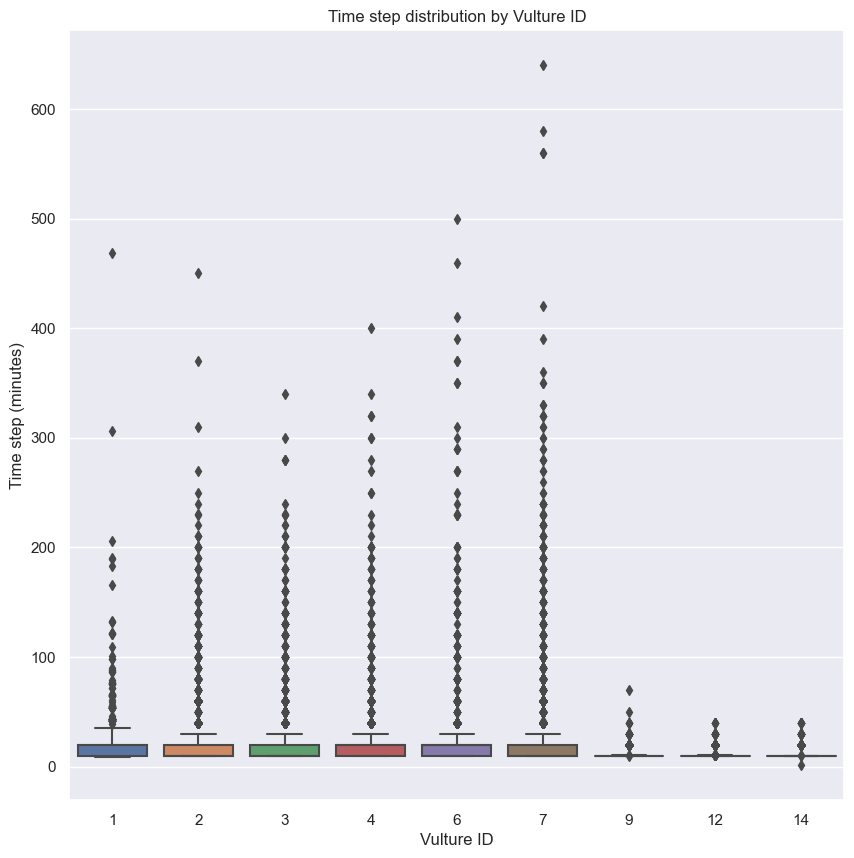

In [279]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.boxplot(data=tb_vulture, x="individual-local-identifier", y="time_step")
ax.set_xlabel("Vulture ID")
ax.set_ylabel("Time step (minutes)")
ax.set_title("Time step distribution by Vulture ID")


In [280]:
(
    tb_vulture.groupby(["individual-local-identifier", "day"])["time_step"]
    .count()
    .reset_index()
    .groupby("individual-local-identifier")
    .count()
    .reset_index()
    .drop(columns="day")
    .rename(columns={"time_step": "num_days"})
)


individual-local-identifier  num_days
0                            1       113
1                            2       421
2                            3       341
3                            4       309
4                            6       193
5                            7       562
6                            9       368
7                           12       380
8                           14       392

In [281]:
tb_vulture["timestep_outlier"] = np.where(tb_vulture["time_step"] >= 60, 1, 0)
tb_vulture["day_with_ts_outlier"] = tb_vulture.groupby(
    ["individual-local-identifier", "day"]
)["timestep_outlier"].transform("max")


In [282]:
(
    tb_vulture.groupby(["individual-local-identifier", "day"])
    .agg(outlier=("timestep_outlier", "max"))
    .reset_index()
    .groupby("individual-local-identifier")
    .agg(num_day_w_outlier=("outlier", "sum"), num_day=("outlier", "count"))
    .reset_index()
)


individual-local-identifier  num_day_w_outlier  num_day
0                            1                 35      113
1                            2                270      421
2                            3                208      341
3                            4                193      309
4                            6                113      193
5                            7                355      562
6                            9                  1      368
7                           12                  0      380
8                           14                  0      392

Text(0.5, 0.91, 'Vulture Flight Paths')

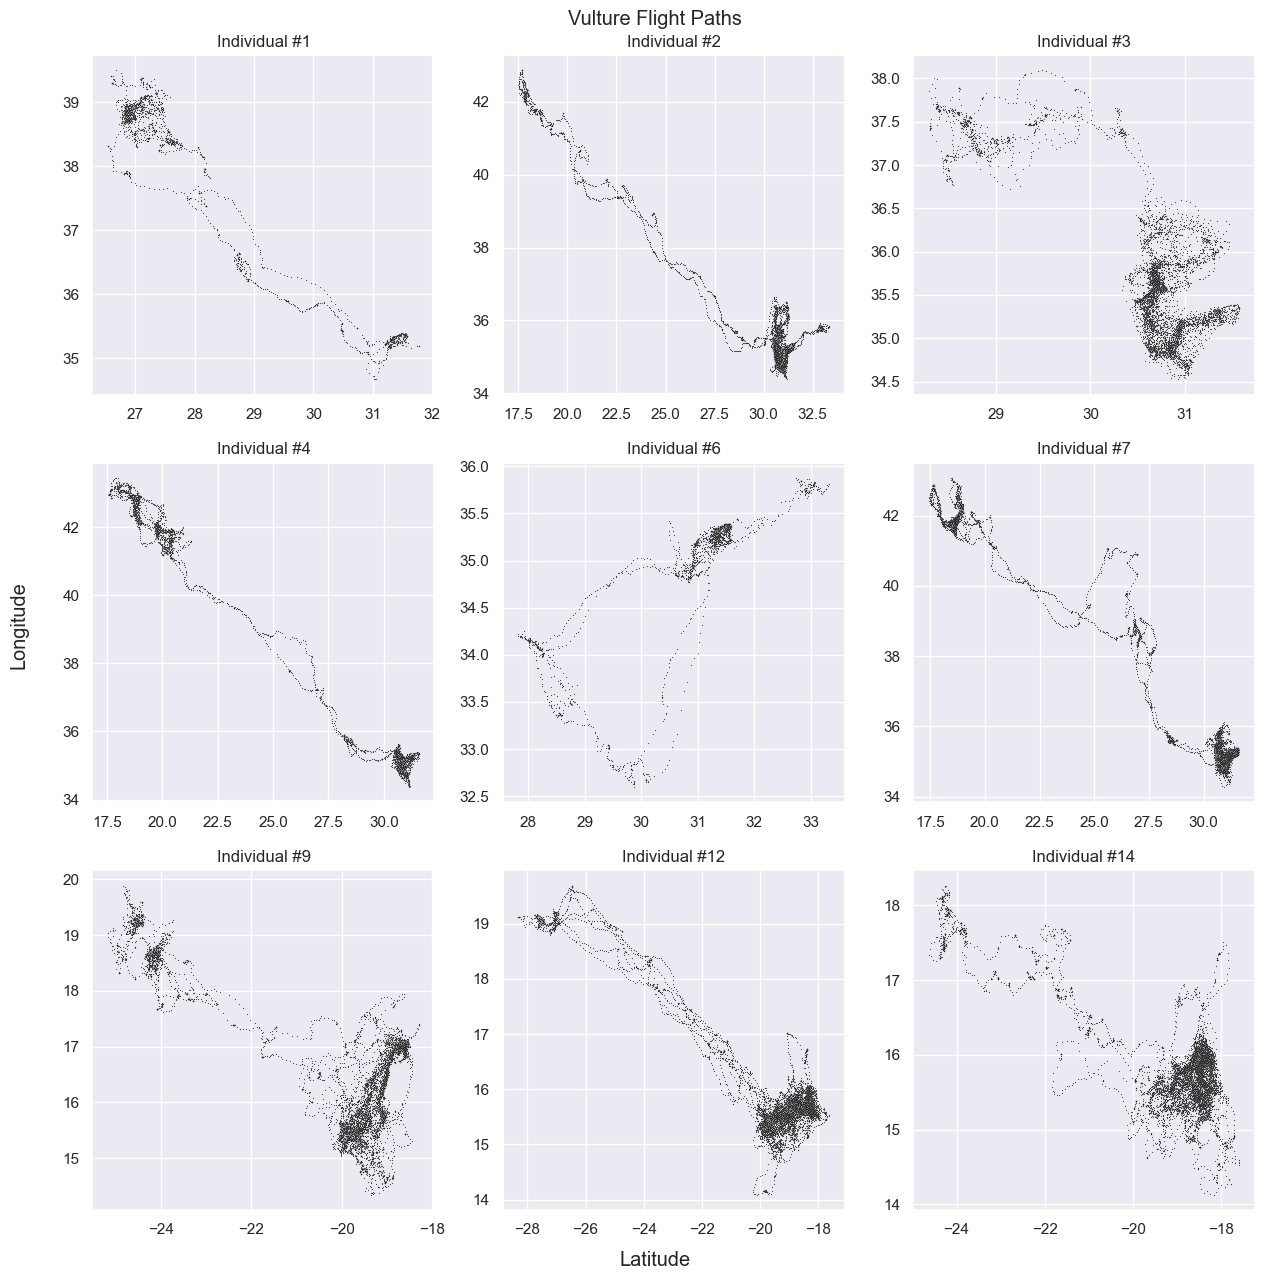

In [283]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, (name, group) in enumerate(tb_vulture.groupby("individual-local-identifier")):
    sns.scatterplot(
        x="location-lat",
        y="location-long",
        data=group,
        ax=ax[i // 3, i % 3],
        color="black",
        s=0.7,
        alpha=0.8,
    )
    ax[i // 3, i % 3].set_title(f"Individual #{name}")
    ax[i // 3, i % 3].set_xlabel("")
    ax[i // 3, i % 3].set_ylabel("")
fig.supxlabel("Latitude", y=0.07)
fig.supylabel("Longitude", x=0.07)
fig.suptitle("Vulture Flight Paths", y=0.91)


Text(0.5, 0.91, 'Vulture Flight Paths')

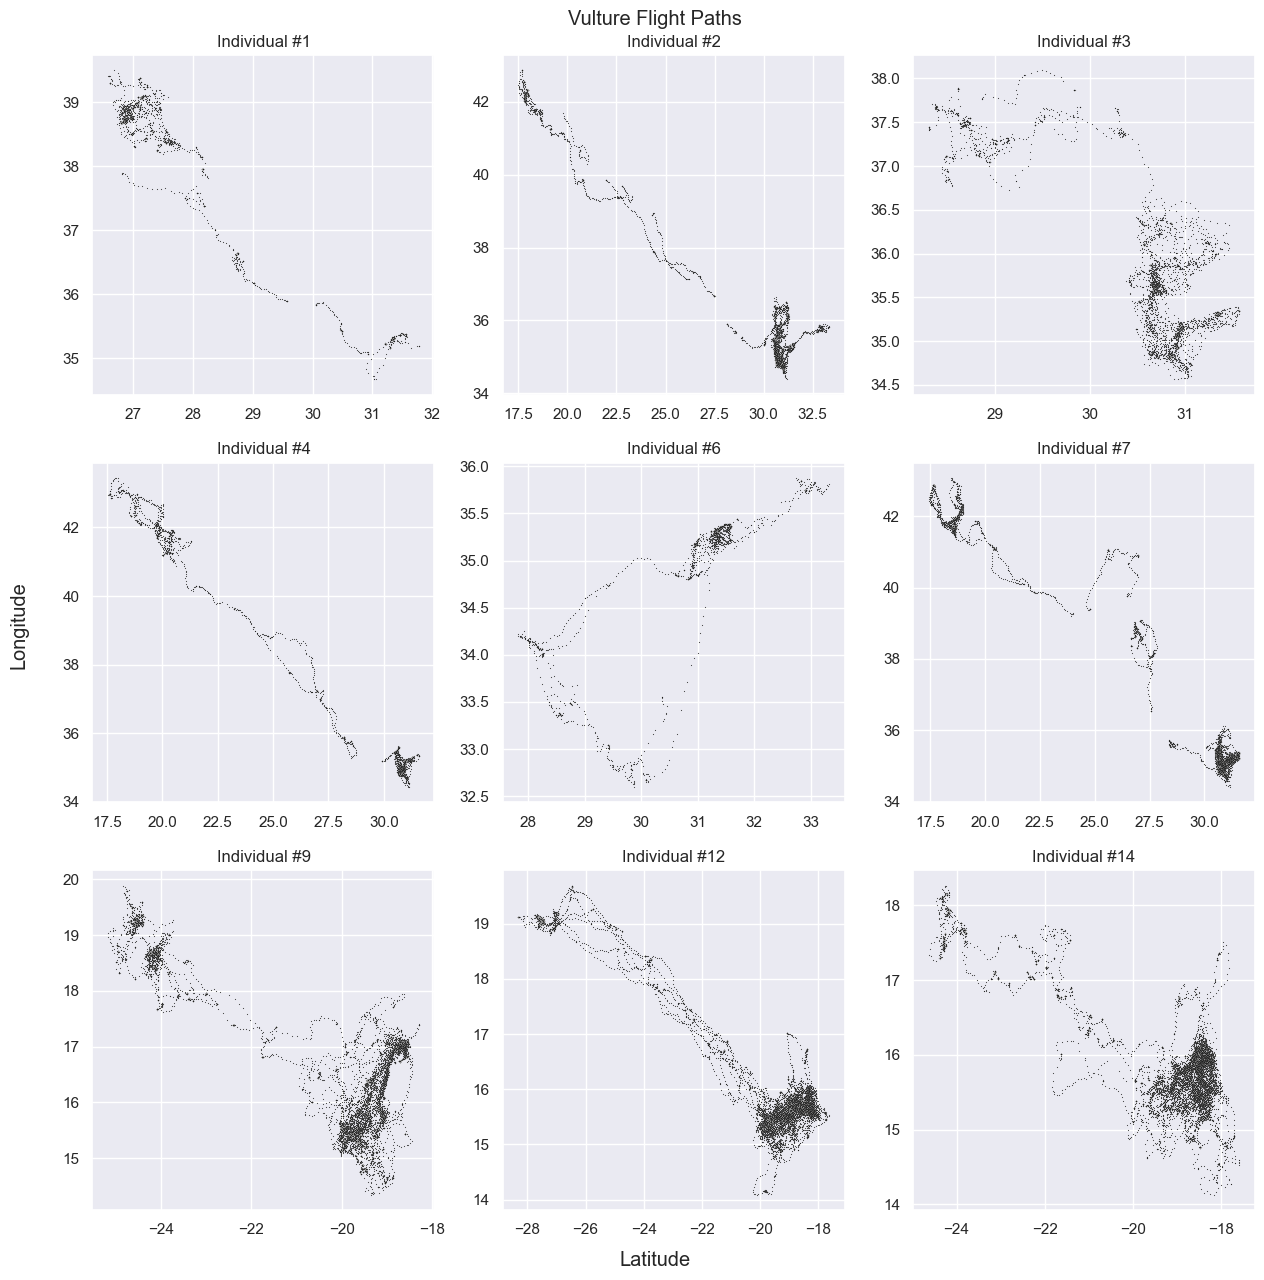

In [284]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, (name, group) in enumerate(
    tb_vulture[tb_vulture["day_with_ts_outlier"] == 0].groupby(
        "individual-local-identifier"
    )
):
    sns.scatterplot(
        x="location-lat",
        y="location-long",
        data=group,
        ax=ax[i // 3, i % 3],
        color="black",
        s=0.7,
        alpha=0.8,
    )
    ax[i // 3, i % 3].set_title(f"Individual #{name}")
    ax[i // 3, i % 3].set_xlabel("")
    ax[i // 3, i % 3].set_ylabel("")
fig.supxlabel("Latitude", y=0.07)
fig.supylabel("Longitude", x=0.07)
fig.suptitle("Vulture Flight Paths", y=0.91)


In [285]:
tb_vulture_nout = tb_vulture[tb_vulture["day_with_ts_outlier"] == 0].copy()


# Creating attitude variables

In [286]:
lat_long_var_l1 = [
    "location-lat",
    "location-long",
    "location-lat-l1",
    "location-long-l1",
]
tb_vulture_nout["distance_l1"] = tb_vulture_nout[lat_long_var_l1].apply(
    lambda x: distance(*x), axis=1
)
tb_vulture_nout["heading_l1"] = tb_vulture_nout[lat_long_var_l1].apply(
    lambda x: heading(*x), axis=1
)
tb_vulture_nout["prev_heading_l1"] = tb_vulture_nout.groupby(
    ["individual-local-identifier", "day"]
)["heading_l1"].shift()
tb_vulture_nout["heading_diff_l1"] = tb_vulture_nout[
    ["heading_l1", "prev_heading_l1"]
].apply(lambda x: angle_distance(*x), axis=1)
tb_vulture_nout["velocity_l1"] = tb_vulture_nout["distance_l1"] / (
    tb_vulture_nout["time_step"] / 60
)


In [287]:
lat_long_var_l6 = [
    "location-lat",
    "location-long",
    "location-lat-l6",
    "location-long-l6",
]
tb_vulture_nout["distance_l6"] = tb_vulture_nout[lat_long_var_l6].apply(
    lambda x: distance(*x), axis=1
)
tb_vulture_nout["heading_l6"] = tb_vulture_nout[lat_long_var_l6].apply(
    lambda x: heading(*x), axis=1
)
tb_vulture_nout["prev_heading_l6"] = tb_vulture_nout.groupby(
    ["individual-local-identifier", "day"]
)["heading_l6"].shift()
tb_vulture_nout["heading_diff_l6"] = tb_vulture_nout[
    ["heading_l6", "prev_heading_l6"]
].apply(lambda x: angle_distance(*x), axis=1)
tb_vulture_nout["velocity_l6"] = tb_vulture_nout["distance_l6"] / (
    tb_vulture_nout["time_step_l6"] / 60
)
tb_vulture_nout["heading_deviation"] = tb_vulture_nout[
    ["heading_l1", "heading_l6"]
].apply(lambda x: angle_distance(*x), axis=1)
tb_vulture_nout["velocity_deviation"] = (
    tb_vulture_nout["velocity_l6"] - tb_vulture_nout["velocity_l1"]
)


Text(0.5, 0.91, 'Vulture Flight Paths')

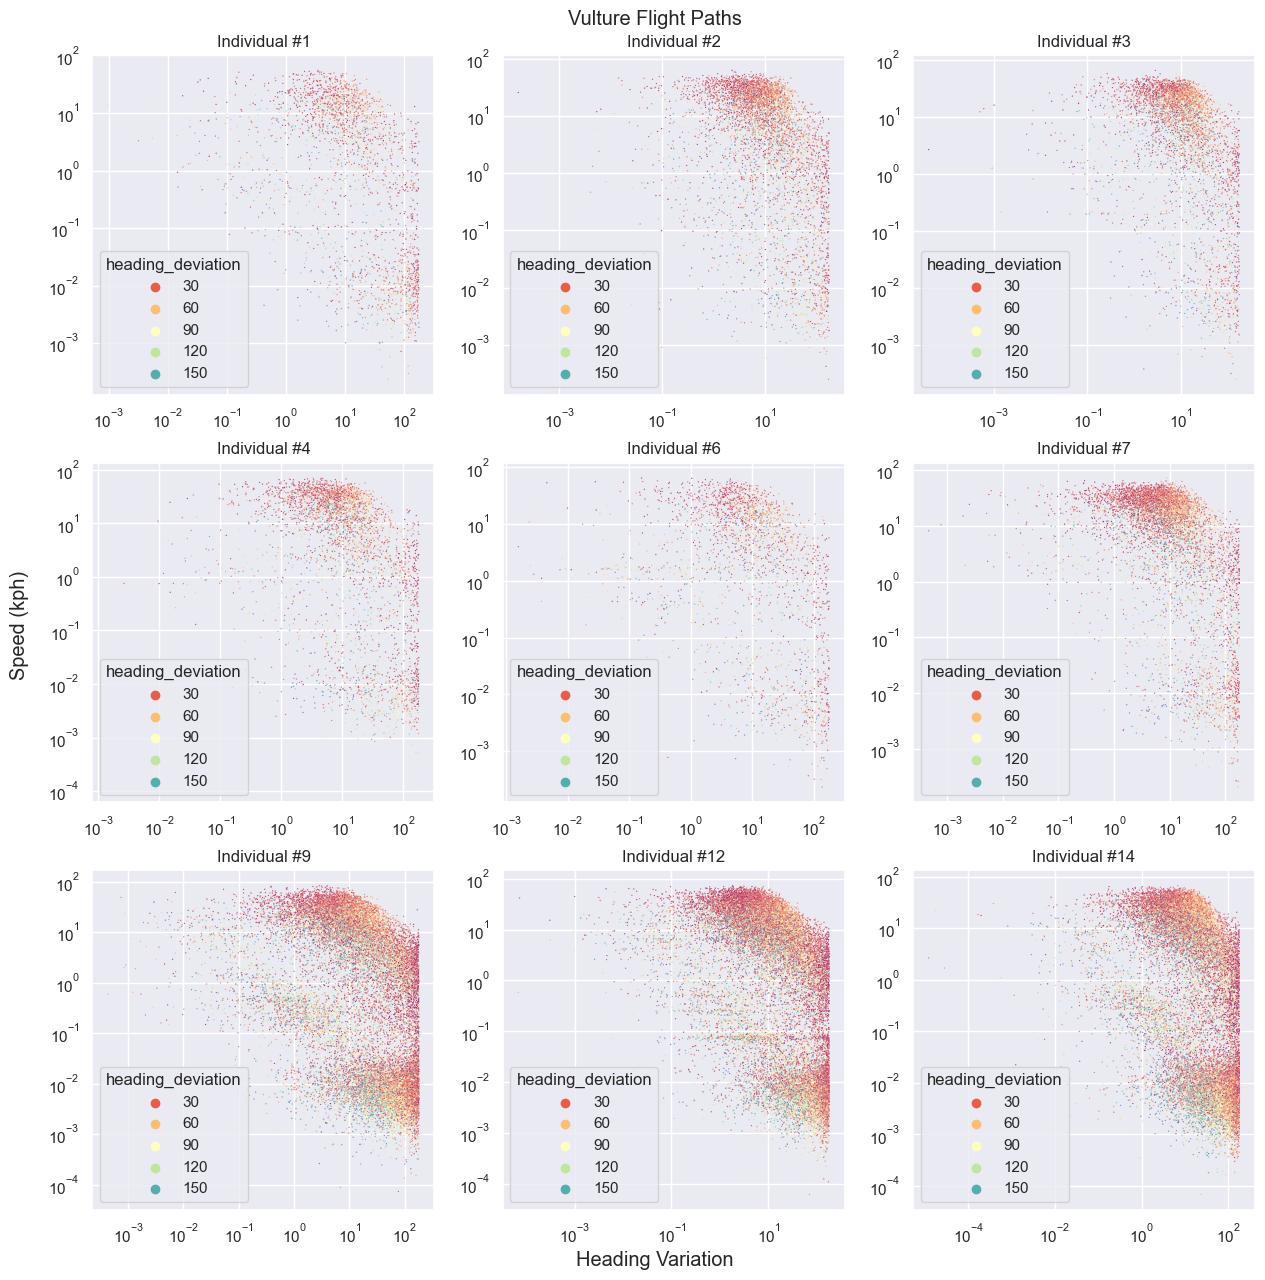

In [288]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, (name, group) in enumerate(
    tb_vulture_nout.groupby("individual-local-identifier")
):
    sns.scatterplot(
        x="heading_diff_l6",
        y="velocity_l6",
        data=group,
        ax=ax[i // 3, i % 3],
        hue="heading_deviation",
        palette="Spectral",
        s=0.9,
        alpha=0.8,
    )
    ax[i // 3, i % 3].set_title(f"Individual #{name}")
    ax[i // 3, i % 3].set_xlabel("")
    ax[i // 3, i % 3].set_ylabel("")
    ax[i // 3, i % 3].set_xscale("log")
    ax[i // 3, i % 3].set_yscale("log")
fig.supxlabel("Heading Variation", y=0.07)
fig.supylabel("Speed (kph)", x=0.07)
fig.suptitle("Vulture Flight Paths", y=0.91)


Text(0.5, 0.91, 'Vulture Flight Paths')

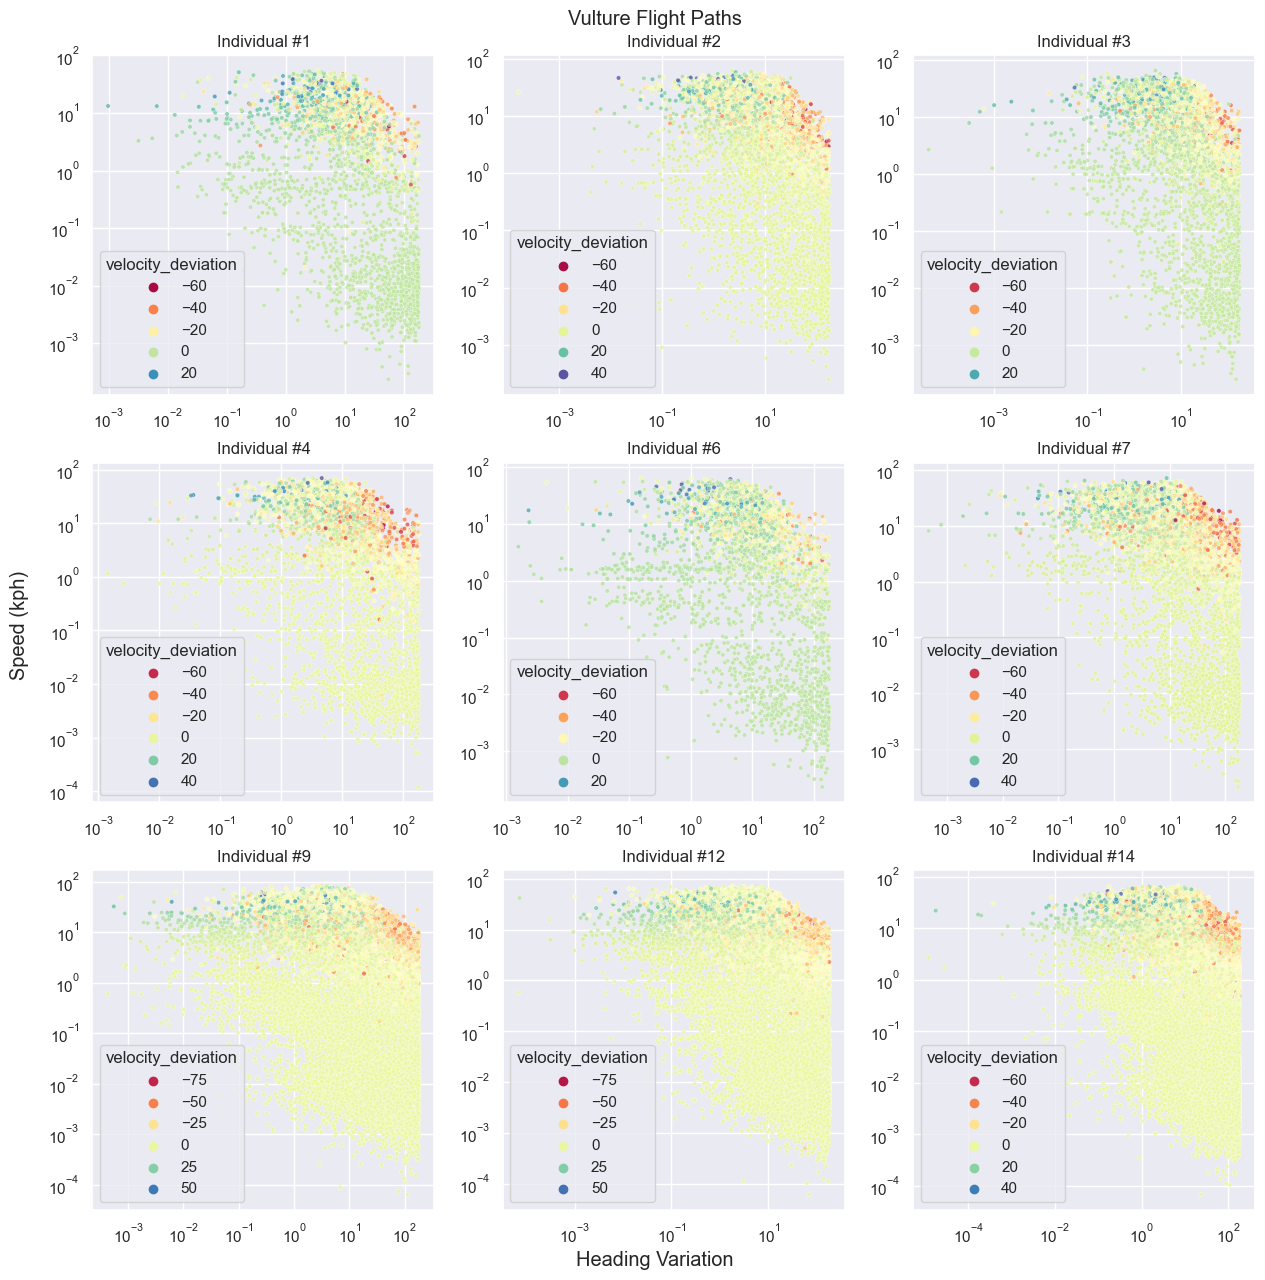

In [290]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, (name, group) in enumerate(
    tb_vulture_nout.groupby("individual-local-identifier")
):
    sns.scatterplot(
        x="heading_diff_l6",
        y="velocity_l6",
        data=group,
        ax=ax[i // 3, i % 3],
        hue="velocity_deviation",
        palette="Spectral",
        s=2,
        alpha=0.5,
    )
    ax[i // 3, i % 3].set_title(f"Individual #{name}")
    ax[i // 3, i % 3].set_xlabel("")
    ax[i // 3, i % 3].set_ylabel("")
    ax[i // 3, i % 3].set_xscale("log")
    ax[i // 3, i % 3].set_yscale("log")
fig.supxlabel("Heading Variation", y=0.07)
fig.supylabel("Speed (kph)", x=0.07)
fig.suptitle("Vulture Flight Paths", y=0.91)


In [295]:
tb_vulture_nout["norm_heading_diff_l6"] = tb_vulture_nout.groupby(
    "individual-local-identifier"
)["heading_diff_l6"].transform(lambda x: (x - x.mean()) / x.std())
tb_vulture_nout["norm_velocity_l6"] = tb_vulture_nout.groupby(
    "individual-local-identifier"
)["velocity_l6"].transform(lambda x: (x - x.mean()) / x.std())
tb_vulture_nout["norm_heading_deviation"] = tb_vulture_nout.groupby(
    "individual-local-identifier"
)["heading_deviation"].transform(lambda x: (x - x.mean()) / x.std())
tb_vulture_nout["norm_velocity_deviation"] = tb_vulture_nout.groupby(
    "individual-local-identifier"
)["velocity_deviation"].transform(lambda x: (x - x.mean()) / x.std())


Text(0.5, 0.91, 'Vulture Flight Paths')

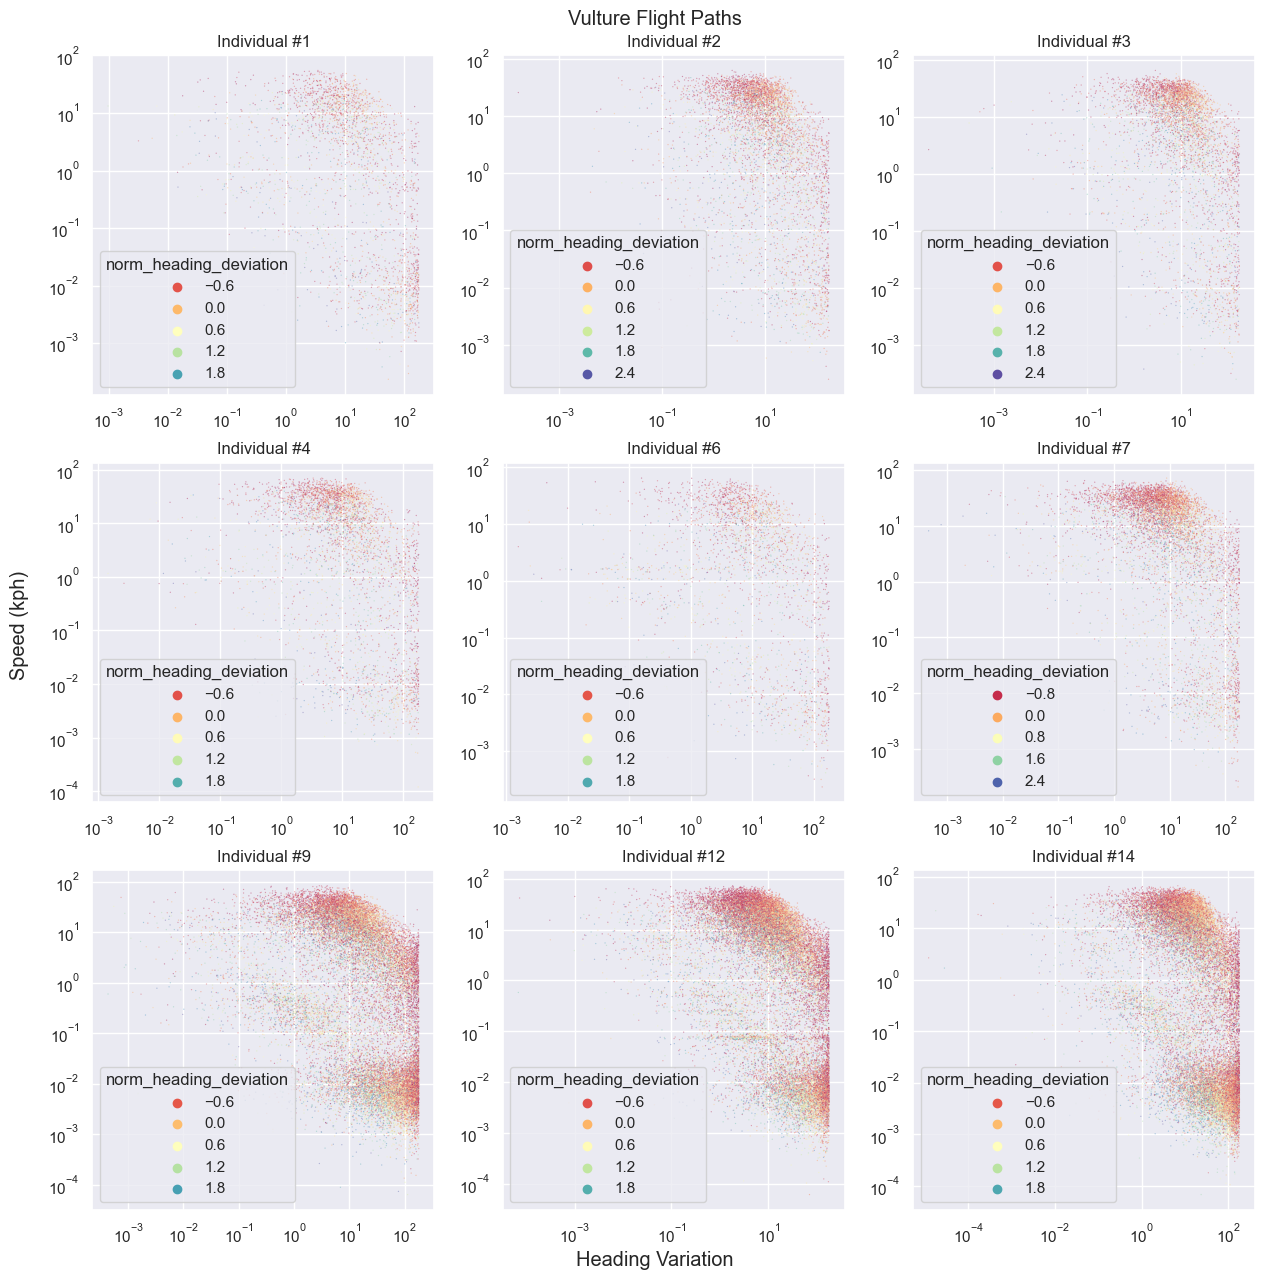

In [304]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, (name, group) in enumerate(
    tb_vulture_nout.groupby("individual-local-identifier")
):
    sns.scatterplot(
        x="heading_diff_l6",
        y="velocity_l6",
        data=group,
        ax=ax[i // 3, i % 3],
        hue="norm_heading_deviation",
        palette="Spectral",
        s=0.9,
        alpha=0.4,
    )
    ax[i // 3, i % 3].set_title(f"Individual #{name}")
    ax[i // 3, i % 3].set_xlabel("")
    ax[i // 3, i % 3].set_ylabel("")
    ax[i // 3, i % 3].set_xscale("log")
    ax[i // 3, i % 3].set_yscale("log")
fig.supxlabel("Heading Variation", y=0.07)
fig.supylabel("Speed (kph)", x=0.07)
fig.suptitle("Vulture Flight Paths", y=0.91)


Text(0.5, 0.91, 'Vulture Flight Paths')

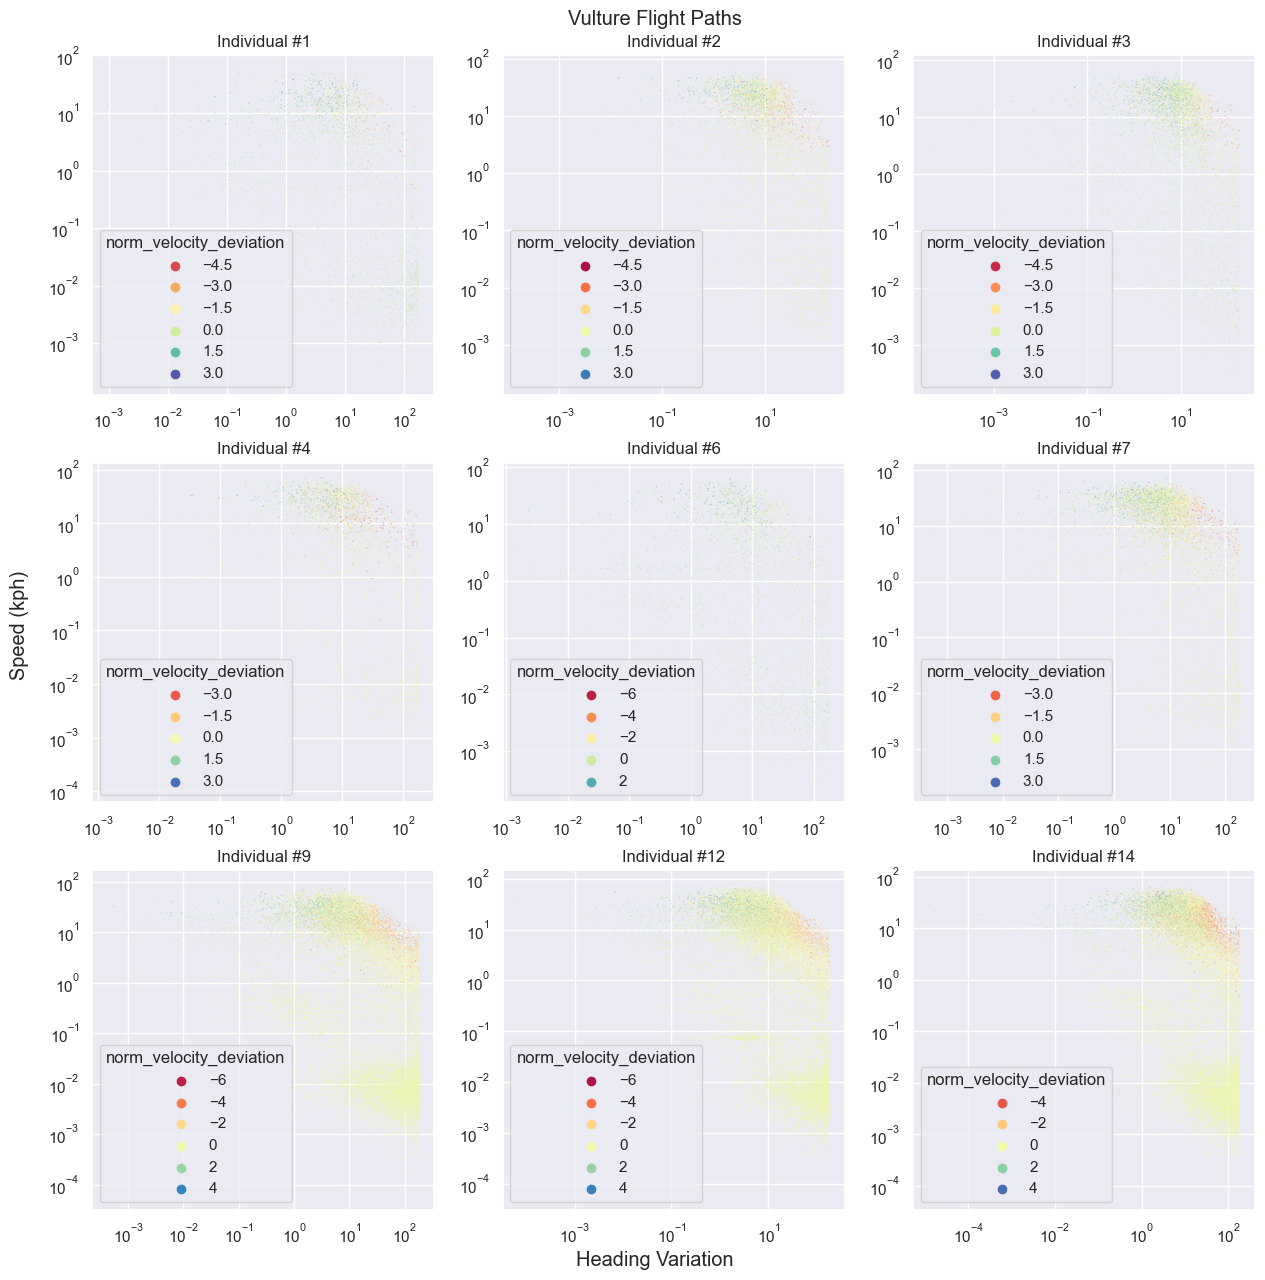

In [305]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, (name, group) in enumerate(
    tb_vulture_nout.groupby("individual-local-identifier")
):
    sns.scatterplot(
        x="heading_diff_l6",
        y="velocity_l6",
        data=group,
        ax=ax[i // 3, i % 3],
        hue="norm_velocity_deviation",
        palette="Spectral",
        s=0.9,
        alpha=0.4,
    )
    ax[i // 3, i % 3].set_title(f"Individual #{name}")
    ax[i // 3, i % 3].set_xlabel("")
    ax[i // 3, i % 3].set_ylabel("")
    ax[i // 3, i % 3].set_xscale("log")
    ax[i // 3, i % 3].set_yscale("log")
fig.supxlabel("Heading Variation", y=0.07)
fig.supylabel("Speed (kph)", x=0.07)
fig.suptitle("Vulture Flight Paths", y=0.91)


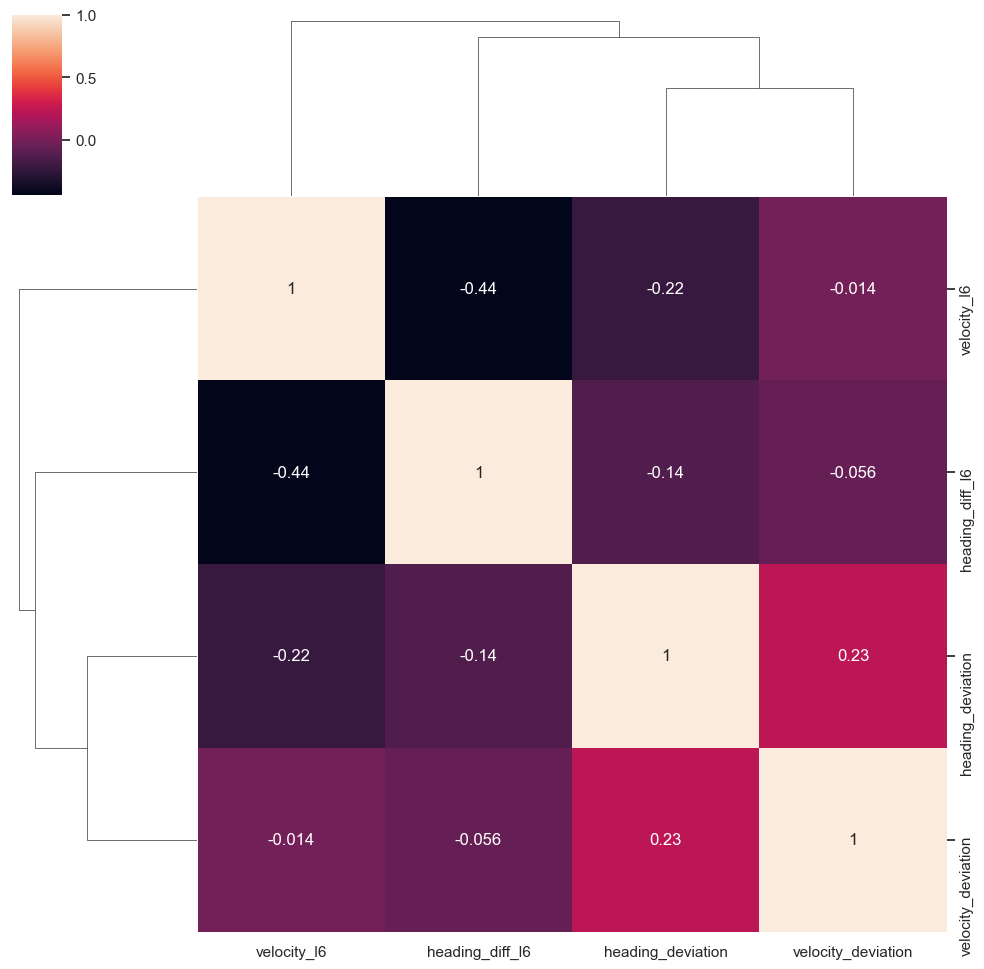

In [306]:
sns.clustermap(
    tb_vulture_nout[
        ["heading_diff_l6", "velocity_l6", "heading_deviation", "velocity_deviation"]
    ].corr(),
    annot=True,
)


In [307]:
clu_vars = ["heading_diff_l6", "velocity_l6", "heading_deviation", "velocity_deviation"]


In [308]:
# create a list of K values to evaluate
ks_to_evaluate = range(2, 9)
batch_size = max_cores * 256
# create an empty array to store the results
results_arr = np.zeros((len(ks_to_evaluate), 3))
X = tb_vulture_nout[clu_vars].dropna()
for i, k in enumerate(ks_to_evaluate):
    print(f"Running KMeans with K={k}...")
    # instantiate KMeans with current K value
    p_trans = PowerTransformer()
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=batch_size)
    clu_pipeline = Pipeline([("POWERTRANS", p_trans), ("KMEANS", kmeans)])

    # fit the model to the data and make predictions
    labels = clu_pipeline.fit_predict(X)

    # calculate silhouette score and inertia
    silhouette = silhouette_score(X, labels)
    inertia = clu_pipeline.steps[1][1].inertia_

    # update the results array
    results_arr[i, 0] = k
    results_arr[i, 1] = silhouette
    results_arr[i, 2] = inertia

# create a DataFrame from the results array
results_df = pd.DataFrame(results_arr, columns=["K", "Silhouette", "Inertia"])


Running KMeans with K=2...
Running KMeans with K=3...
Running KMeans with K=4...


KeyboardInterrupt: 